In [6]:
from dotenv import load_dotenv

load_dotenv()

True

Найдем пример промта для langchain агента

Инструмент для поиска:

In [8]:
from langchain_community.tools import TavilySearchResults

tavily_tool = TavilySearchResults(
    max_results=5, 
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=False
)

Инструмент text2SQL:

In [51]:
from text2sql_module.clients.client_text2data import Text2SQLClient
from langchain_community.tools import tool
from typing import Annotated

text2sql_client = Text2SQLClient(base_url="http://127.0.0.1:8000")

@tool
def text2sql_tool(
        query: Annotated[str, "text query that you should execute over database"] # TODO prompt
):
    """You has a database with transactions of user that asked you a question. If you need some information, convert text query to sql, execute it and return output data"""  # TODO prompt
    try:
        result = text2sql_client.execute_query(query)
        print("Результат запроса:")
        print(result)
    except RuntimeError as e:
        print(f"Произошла ошибка: {e}")

### OpenAI GPT-3.5

Для начала соберем решение на купленном токене OpenAI.

Основная архитектура:
Planner: https://langchain-ai.github.io/langgraph/tutorials/plan-and-execute/plan-and-execute/
Supervisor: https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/
create_react_agent: https://langchain-ai.github.io/langgraph/reference/prebuilt/ - он использует bind_tools
Также нам потребуется with_structured_output() метод для llm

In [52]:
from typing import TypedDict, List, Tuple
import operator
from langgraph.graph.message import add_messages, AnyMessage
from langgraph.graph import StateGraph, START, END

class ExecutorState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]  # Класс с атрибутами. Появляется аттрибут tool_calls, если тула была вызвана
    user_id: int
    is_last_step: bool
    
class PlanState(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

Создадим React экзекутора (
    Act - call tools, 
    Observe - pass tool output back, 
    Reason - decide what to do next
)
Пока он будет сразу получать план и работать со всеми инструменты, но далее все инструменты мы вынесем в отдельных агентов, способных к саморефлексии и улучшения ответа. Особенно это будет полезно для text2sql модуля

In [59]:
from langgraph.prebuilt import create_react_agent, tools_condition, ToolNode
from langchain_openai import ChatOpenAI
from langchain import hub

prompt = hub.pull("ih/ih-react-agent-executor")
prompt.pretty_print()

llm = ChatOpenAI(temperature=0)
executor_agent = create_react_agent(
    llm, tools=[tavily_tool], state_modifier=prompt, #state_schema=State
)  # автоматически создает граф из агента и тулзов

================================ System Message ================================

You are a helpful assistant.

============================= Messages Placeholder =============================

{messages}


Теперь создадим планнер

In [60]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order" # TODO
    )
    
planner_llm = ChatOpenAI()

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)  # TODO planner prompt
planner = planner_prompt | planner_llm.with_structured_output(Plan)

Создадим репланнер.
Его задача - корректировать план на основе выполненных шагов: убирать уже сделанное и добавлять новое

In [61]:
from typing import Union


class Response(BaseModel):
    """Response to user."""
    response: str


class Act(BaseModel):
    """Action to perform."""
    action: Union[Response, Plan] = Field(
        description="Action to perform. If you think that plan has finished and you are ready to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan." # TODO
    )  # может вернуть финальный ответ или новый план

replanner_model = ChatOpenAI(temperature=0)

replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | replanner_model.with_structured_output(Act)

Создадим всех агентов для нод внутри
Дальше при помощи условных связей будем направлять ноды

In [63]:
from typing import Literal
from langgraph.graph import END, START


def executor_step(state: PlanState):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = executor_agent.invoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


def planner_step(state: PlanState):
    plan = planner.invoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


def replanner_step(state: PlanState):
    output = replanner.invoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanState):
    if "response" in state and state["response"]:
        return END
    else:
        return "executor"

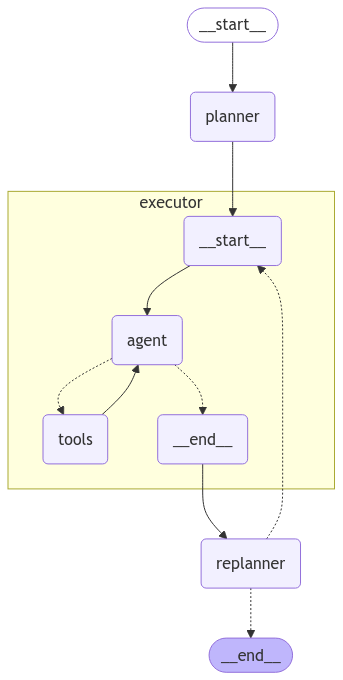

In [64]:
from IPython.display import Image, display
from langgraph.graph import StateGraph

graph_builder = StateGraph(PlanState)

graph_builder.add_node("planner", planner_step)
graph_builder.add_node("executor", executor_step)
graph_builder.add_node("replanner", replanner_step)

graph_builder.add_edge(START, "planner")
graph_builder.add_edge("planner", "executor")
graph_builder.add_edge("executor", "replanner")
graph_builder.add_conditional_edges("replanner", should_end, {"executor": "executor", END: END})

graph = graph_builder.compile()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
config = {"recursion_limit": 50}
inputs = {"input": "what is the hometown of the mens 2024 Australia open winner?", "input2": "Who am i?"}

async for event in graph.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

In [49]:
graph.invoke({"input": "могу ли я позволить себе пачку доширака?"})

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

### Free Qwen


Два варианта привязки инструментов:
1. Переопределние bind_tools при помощи промта
2. Использование AgentExecutor вместо create_react_agent. Он тоже работает в рамках архитектуры ReAct

Для structured output можно найти и заиспользовать внешний фреймворк

#### Переопределение bind_tools

В bind_tools нужно задать промт, который будет давать моедли список инструментов и парсить выход, подавай на вход еще раз

In [5]:
# from langchain import hub
# 
# prompt = hub.pull("hwchase17/react-json")
# prompt[0]

In [6]:
from langchain_core.language_models.llms import LLM
from gradio_client import Client
from pydantic import Field
from typing import Any

class Qwen(LLM):
    llm_client: Client = Field(default=None)  # запретить явно ставить извне
    tools: list = Field(default=None)
    
    def model_post_init(self, __context: Any) -> None:
        self.llm_client = Client("Qwen/Qwen2.5")
        self.tools = []
        
    def _call(
        self,
        query: str,
        **kwargs: Any,
    ) -> str:
        result = self.llm_client.predict(
                query=query,
                history=[],
                system="",
                radio="72B",
                api_name="/model_chat"
        )
        text_answer = result[1][0][-1]['text']
        return text_answer
    
    @property
    def _llm_type(self) -> str:  # нужно только для логирования
        return f"Planner, using Qwen"
    
    def bind_tools(self, tools: list):
        self.tools = tools.copy()
        return self

#### Агент langchain вместо графа

In [76]:
from langchain.agents import initialize_agent, AgentType
from langchain_core.prompts import PromptTemplate

executor_agent = initialize_agent(
    tools=[tavily_tool],
    llm=llm,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    handle_parsing_errors=True,
)

In [7]:
# from langchain import hub
# 
# prompt = hub.pull("hwchase17/react-json")

# {tool_names} - список названий
# {tools} - сами тулы в каком-то виде
# {
#     action - имя тулзы
#     action_input - инпут тулзы в виде json
# }
# 
# Итоговый аутпут:
# Question: вопрос юзера
# Thought: рефлексия
# Action: действие
# Observation: результат действия
# Final Answer: итоговый ответ на инпут
# 
# Промт ничего не гвоорит о заврешении генерации